In [ ]:
import pandas as pd
import seaborn as sns
import requests
from bs4 import BeautifulSoup as bs
import re
from dfply import *
import matplotlib.pyplot as plt
import matplotlib as mpl



### Функция для получения нужных страниц форума

In [ ]:
def parse_forum(url, starts, headers):
    result = []
    for start in starts:
        request = requests.get(url = url + str(start), headers = headers)
        result.append(bs(request.text, 'html.parser'))
    return result

### Функция для спарсивания нужных кусков страницы  
(del нужно, потому что на каждой странице вверху есть опрос, который тоже спарсивается, но не нужен)

In [ ]:
def parse_soups(soups, tag, class_, delete = True):
    result = []
    for el in soups:
        content = el.find_all(tag, class_ = class_)
        if delete == True:
            del content[0]
        for elem in content:
            result.append(elem.text.strip())
    return result

###  Парсим все страницы форума  
starts содержит номер сообщения, с которого будет начинаться страница, на странице помещается 20 сообщений.  
Чтобы спарсить сообщения, которые появятся потом, нужно будет добавить нужные значения в список

In [ ]:
starts = [0,20, 40, 60, 80, 100, 120, 140]
headers = {
    'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.5 Safari/605.1.15',
    'cookie': '_ga_W0JDW2V29Y=GS1.1.1661181837.2.1.1661184512.60.0.0; _ga=GA1.2.1025230771.1661155454; _gid=GA1.2.721157209.1661155454; style_cookie=null; phpbb3_alft2_k=; phpbb3_alft2_sid=fa5f9f17fa55d5a1a82d62c62159899a; phpbb3_alft2_u=1'
}

soups = parse_forum('https://forum.awd.ru/viewtopic.php?f=521&t=397637&start=', starts, headers)

### Парсим из страниц форума содержание и блок «автор», в котором содержится дата

In [ ]:
contents = parse_soups(soups, 'div', 'content')
authors = parse_soups(soups, 'p', 'author')

Проверяем, все ли ок с длиной  
Если она соответствует количеству сообщений на форуме, то все ок

In [ ]:
print(len(contents))
print(len(authors))

### Функция для парсинга конкретных данных по регулярному выражению  
Айди нужен, чтобы потом вручную прописать данные, которые не спарсятся, и не потерять порядок людей
hard = True нужен, потому что в сообщениях по июлю много «5.», он втупую несколько раз режет оставшееся

In [ ]:
def get_data(regex, list, group_num = 2, hard = False, hard_regex = '(5\.)(.*)'):
    result = []
    for value in list:
        try:
            reg = re.search(regex, value).group(group_num).strip()
            
            if hard == True:
                for i in range(3):
                    try:
                        reg = re.search(hard_regex, reg).group(2).strip()
                    except:
                        break
                        
                        
            result.append(reg)
        except:
            result.append(" NaN")
    return result

### Парсим все нужные нам данные по регулярным выражениям  
  
Через del удаляем первые строки на каждой странице — в них содержится закрепленное сообщение модератора

In [ ]:
date = get_data('\d\d\s\w{2,4}\s\d\d\d\d', authors, 0)
city = get_data('(1\.)(.*?)(2\.)', contents)
visa_center = get_data('(2\.)(.*?)(3\.)', contents) 
raw_history = get_data('(4\.)(.*?)(5\.)', contents)
raw_limit = get_data('(5\.)(.+?)(6\.)', contents, hard = True)

del date[0]
del city[0]
del visa_center[0]
del raw_history[0]
del raw_limit[0]

number = list(range(2, len(date) + 2))


### Категоризуем данные визовой истории  
Хочу категоризовать на две группы:
- По длительности;
- По странам — Германия и не Германия.
#### По длительности

In [ ]:
history = []

for text in raw_history:
    if (
        'нет' in text.lower()
        ):
        history.append("Нет")
        
    elif (
        'лет' in text.lower()
        ):
        history.append('Годовые и больше')
        
    elif (
        ('полг' not in text.lower() or
        'пол ' not in text.lower()) and
        'год' in text.lower()
        ):
        history.append('Годовые и больше')
        
    elif (
        'полг' in text.lower() or
        'пол ' in text.lower()
        ):
        history.append('Полугодовые')
        
    elif (
        "мес" in text.lower()
        ):
        history.append('Меньше полугода')
        
    elif (
        'дне' in text.lower() or
        'кратко' in text.lower()
        ):
        history.append('Меньше полугода')
        
    elif (
        'поезд' in text.lower()
        ):
        history.append('Даты поездки')
        
    elif (
        'чист' in text.lower() or
        'никогда' in text.lower() or
        'не бы' in text.lower()
        ):
        history.append('Нет')
        
    else:
        history.append('_Не пон_' + text)
        
history

        



#### По странам
Тут я сделал достаточно тупо, оставил больше работы на ручную проверку

In [ ]:
history_country = []

for text in raw_history:
    
    if (
        'немец' in text.lower() or
        'немц' in text.lower() or
        'герма' in text.lower() and
        'отка' not in text.lower()
        ):
        history_country.append("Германия в истории")
        
    elif (
        'чист' in text.lower() or
        'никогда' in text.lower() or
        'не бы' in text.lower()
        ):
        history_country.append('Нет')
        
    else:
        history_country.append('Другие страны')
        
history_country
        




### Категоризуем длину полученных виз

In [ ]:
limit = []

for id, text in enumerate(raw_limit):
    if (
        'отказ' in text.lower()
        ):
        limit.append("Отказ")
        
    elif (
        'лет' in text.lower()
        ):
        limit.append('Год и больше')
        
    elif (
        'пол' not in text.lower() and
        'год' in text.lower()
        ):
        limit.append('Год и больше')
        
    elif (
        'пол ' in text.lower() or
        'полг' in text.lower()
        ):
        limit.append('Полгода')
        
    elif (
        "мес" in text.lower()
        ):
        limit.append('Меньше полугода')
        
    elif (
        'дне' in text.lower()
        ):
        limit.append('Меньше полугода')
        
    elif (
        'поезд' in text.lower()
        ):
        limit.append('Даты поездки')
        
    else:
        limit.append(str(id) +'_Не пон_' + text)
        
limit

        


### Собираем датафрейм

In [ ]:
df = pd.DataFrame()

df['number'] = number
df['date'] = date
df['city'] = city
df['visa_center'] = visa_center
df['history'] = history
df['history_country'] = history_country
df['raw_history'] = raw_history
df['limit'] = limit
df['raw_limit'] = raw_limit


df

# Анализируем  
Несколько пассов руками, где-то час ручной проверки и доработки данных — можно анализировать.  
Сразу же отфильтровываем людей, которые получали визы до того, как Германия начала широко выдавать туристические

In [644]:
df = pd.read_csv('done_data.csv')
df = (
    df >>
    mask((X.date.str.contains('2022')) & (X.date.str.contains('июн') |
                                          X.date.str.contains('июл') |
                                          X.date.str.contains('авг') ))
)
df

,message_number,date,city,visa_center,history,history_country,limit
31,34,03 июн 2022,Калининград,ВЦ визаметрик,Годовые и больше,Другие страны,Год и больше
32,35,10 июн 2022,Санкт-Петербург,ВЦ Визаметрик,Нет,Нет,Даты поездки
33,36,12 июн 2022,Москва,ВЦ визаметрик,Годовые и больше,Другие страны,Год и больше
34,37,15 июн 2022,Екатеринбург,Визовый центр,Годовые и больше,Германия в истории,Год и больше
35,38,21 июн 2022,Москва,ВЦ,Годовые и больше,Другие страны,Год и больше
...,...,...,...,...,...,...,...
148,152,31 авг 2022,Москва,ВЦ Visametric,Меньше полугода,Германия в истории,Год и больше
149,153,31 авг 2022,Москва,ВЦ Visametric,Годовые и больше,Германия в истории,Год и больше
150,154,31 авг 2022,Москва,Визаметрик,Годовые и больше,Другие страны,Год и больше
151,155,31 авг 2022,Калининград,ВЦ,Годовые и больше,Германия в истории,Год и больше


Строчки с датой до 15 июня отрежем вручную, чтобы не заморачиваться

In [645]:
df = df[4:]
df = df.reset_index()
df

,index,message_number,date,city,visa_center,history,history_country,limit
0,35,38,21 июн 2022,Москва,ВЦ,Годовые и больше,Другие страны,Год и больше
1,36,39,23 июн 2022,Москва,ВЦ VISAMETRIC,Годовые и больше,Другие страны,Год и больше
2,37,40,24 июн 2022,Санкт-Петербург,ВЦ Визаметрик,Годовые и больше,Германия в истории,Полгода
3,38,41,24 июн 2022,Москва,ВЦ,Полугодовые,Другие страны,Меньше полугода
4,39,42,28 июн 2022,Москва,ВЦ,Годовые и больше,Германия в истории,Год и больше
...,...,...,...,...,...,...,...,...
113,148,152,31 авг 2022,Москва,ВЦ Visametric,Меньше полугода,Германия в истории,Год и больше
114,149,153,31 авг 2022,Москва,ВЦ Visametric,Годовые и больше,Германия в истории,Год и больше
115,150,154,31 авг 2022,Москва,Визаметрик,Годовые и больше,Другие страны,Год и больше
116,151,155,31 авг 2022,Калининград,ВЦ,Годовые и больше,Германия в истории,Год и больше


In [646]:
df['history'] = pd.Categorical(df["history"], ['Годовые и больше', 'Полугодовые', 'Меньше полугода', 
                                      'Даты поездки', 'Нет', 'Не понять'])
df['limit'] = pd.Categorical(df["limit"], ['Год и больше', 'Полгода', 'Меньше полугода', 
                                      'Даты поездки', 'Отказ'])
df['history_country'] = pd.Categorical(df['history_country'])

Готовимся рисовать графику

In [647]:
plt.style.use('ggplot')
colors = sns.color_palette('Dark2')
mpl.rcParams['figure.dpi'] = 110

### Как выдают визы с хорошей визовой историей  
«Хорошая» — у человека были визы на год и больше

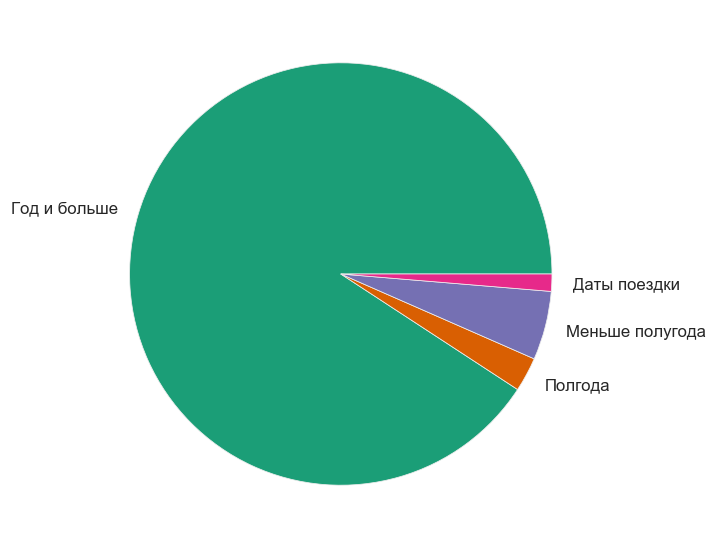

In [648]:
temp = (df >>
        group_by(X.history, X.limit) >>
        summarize(count = n(X.limit)) >>
        mask(X.history == 'Годовые и больше'))

plt.pie(temp['count'], labels = temp['limit'], colors = colors)
plt.title('') 
plt.show()

Сразу видно, что людей с хорошей визовой историей немцы редко обижают  
Ньюанс — количество людей в секторе «год и больше» тут огромное, а во всех остальных секторах людей очень мало.  
Если строить столбчатый график, то это будет выглядеть вот так — зеленый столбик уходит далеко вверх

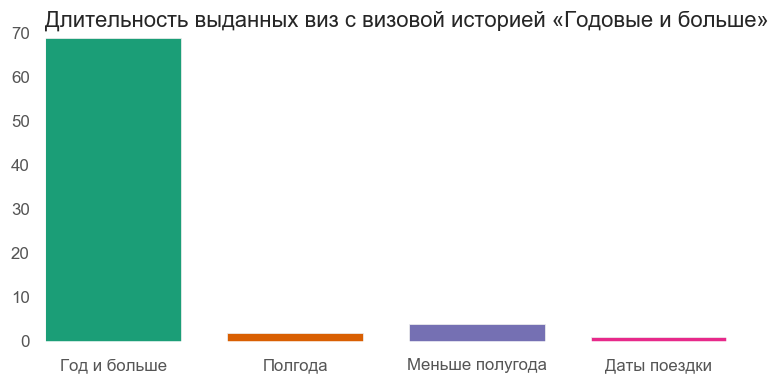

In [649]:
temp = (df >>
        group_by(X.history, X.limit) >>
        summarize(count = n(X.limit)) >>
        mask(X.history == 'Годовые и больше'))

plt.figure(figsize=(8, 3.5))
plt.axes().set_facecolor('white')
plt.bar(height = temp['count'], x = temp['limit'], color = colors, width = .75)
plt.title('Длительность выданных виз с визовой историей «Годовые и больше»',
     loc = 'left')
plt.show()

Возможно, все дело в том, что такие длинные визы получают те, у кого уже были немецкие визы?  
Давайте проверим

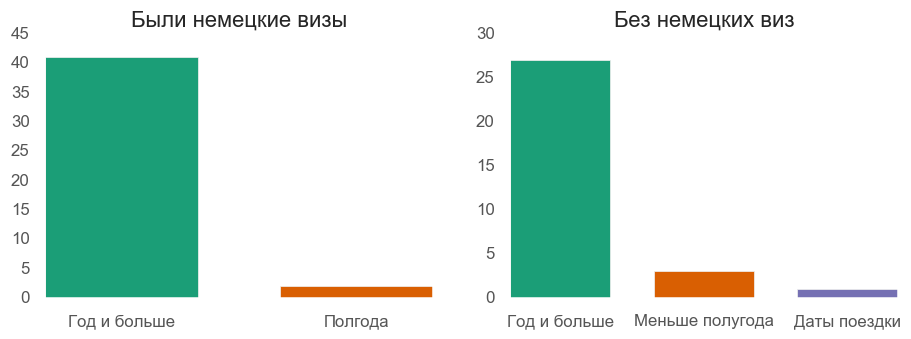

In [650]:
temp = (df >>
        group_by(X.history, X.limit, X.history_country) >>
        summarize(count = n(X.limit)) >>
        mask((X.history == 'Годовые и больше') & (X.history_country == 'Германия в истории'))
       )

temp1 = (df >>
        group_by(X.history, X.limit, X.history_country) >>
        summarize(count = n(X.limit)) >>
        mask((X.history == 'Годовые и больше') & (X.history_country == 'Другие страны'))
       )

figure, axis = plt.subplots(1, 2, figsize=(10, 3))
axis[0].set_facecolor('white')
axis[1].set_facecolor('white')

axis[0].bar(height = temp['count'], x = temp['limit'], color = colors, width = .65)
axis[0].set_title('Были немецкие визы')

axis[1].bar(height = temp1['count'], x = temp1['limit'], color = colors, width = .7)
axis[1].set_title('Без немецких виз')

plt.show()

В общем, вроде бы немцы не обижают людей с хорошей визовой историей, даже если у них раньше не было немецких виз.  
Важное уточнение — я сложил в одну кучу людей с визами на год, два и больше, потому что:  
- У меня не было виз длиннее полугода для меня это все выглядит одинаково много;
- Так было намного проще автоматизированно парсить длину визы.

### Как выдают визы, если были полугодовые

Сначала общее распределение

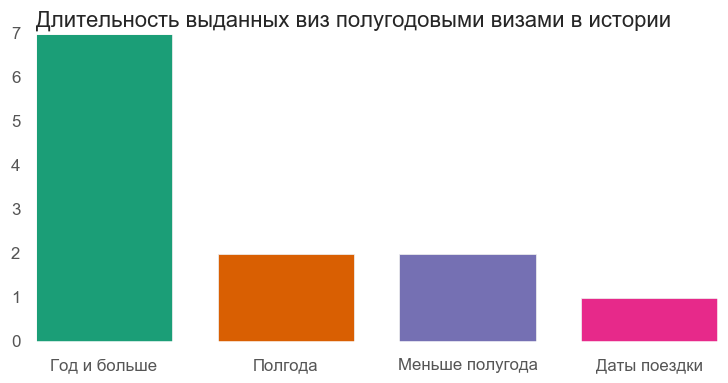

In [651]:
temp = (df >>
        mask(X.history == 'Полугодовые') >>
        group_by(X.history, X.limit) >>
        summarize(count = n(X.limit))
       )

plt.figure(figsize=(8, 3.5))
plt.axes().set_facecolor('white')
plt.bar(height = temp['count'], x = temp['limit'], color = colors, width = .75)
plt.title('Длительность выданных виз полугодовыми визами в истории',
     loc = 'left')
plt.show()

Сразу видно две вещи:  
- Людей в этой категории ну очень мало;
- Тут тоже вроде бы не обижают.

Строим отдельные графики для людей с немецкой историей и без

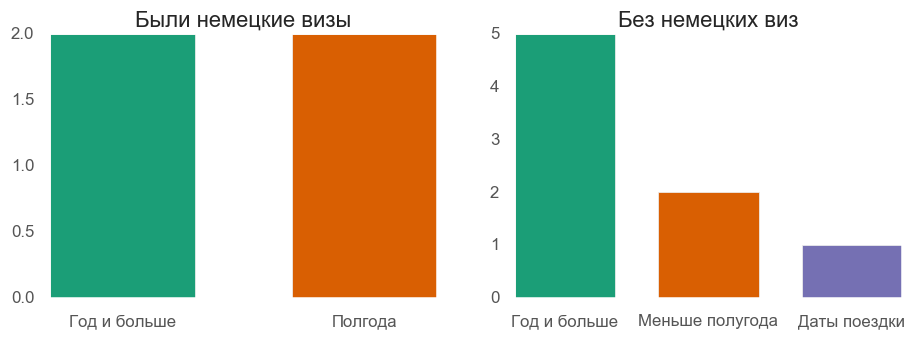

In [652]:
temp = (df >>
        mask((X.history == 'Полугодовые') & (X.history_country == 'Германия в истории')) >>
        group_by(X.history, X.limit, X.history_country) >>
        summarize(count = n(X.limit))
       )

temp1 = (df >>
        group_by(X.history, X.limit, X.history_country) >>
        summarize(count = n(X.limit)) >>
        mask((X.history == 'Полугодовые') & (X.history_country == 'Другие страны'))
       )

figure, axis = plt.subplots(1, 2, figsize=(10, 3))
axis[0].set_facecolor('white')
axis[1].set_facecolor('white')

axis[0].bar(height = temp['count'], x = temp['limit'], color = colors, width = .6)
axis[0].set_title('Были немецкие визы')

axis[1].bar(height = temp1['count'], x = temp1['limit'], color = colors, width = .7)
axis[1].set_title('Без немецких виз')

plt.show()

Оказалось, что людей с полугодовыми визами и Германией в истории очень мало, так что искать скрытый смысл в графике не стоит. Людей без немецкой визовой истории и тут вроде бы не обижают.

Как выдают визы, если раньше были только короткие

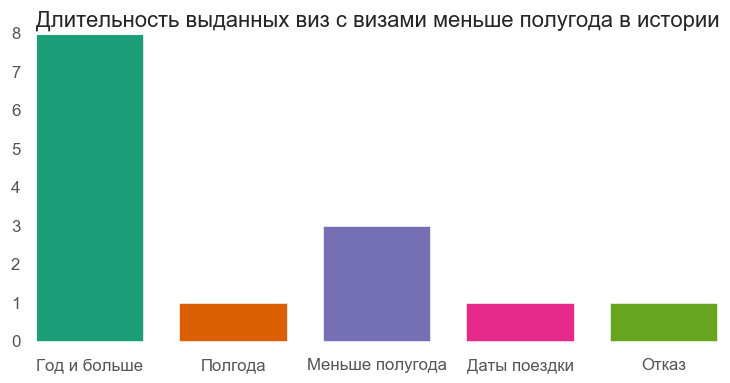

In [653]:
temp = (df >>
        mask((X.history == 'Меньше полугода') |( X.history == 'Даты поездки')) >>
        group_by(X.limit) >>
        summarize(count = n(X.limit))      
       )


plt.figure(figsize=(8, 3.5))
plt.axes().set_facecolor('white')
plt.bar(data = temp, height = 'count', x = 'limit', color = colors, width = .75)
plt.title('Длительность выданных виз с визами меньше полугода в истории',
     loc = 'left')
plt.show()

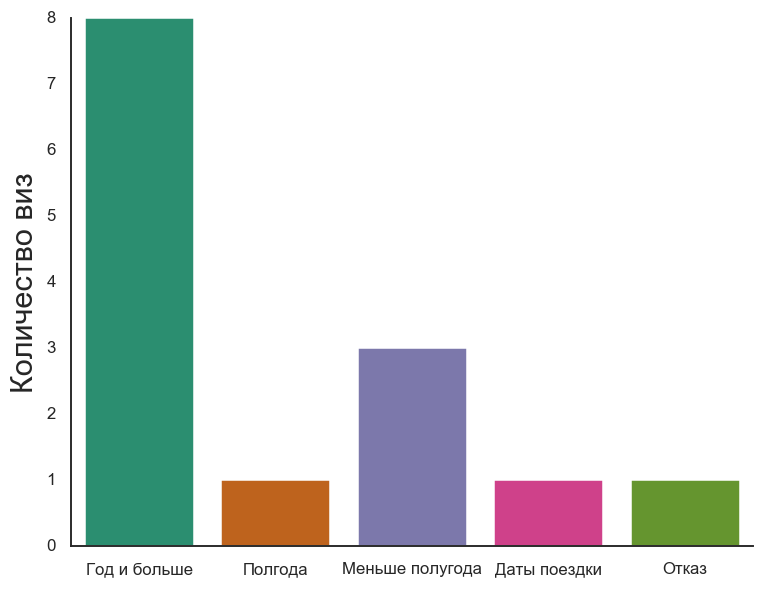

In [643]:
temp = (df >>
        mask((X.history == 'Меньше полугода') |( X.history == 'Даты поездки')) >>
        group_by(X.limit) >>
        summarize(count = n(X.limit))      
       )

plt.axes().set_facecolor('white')

temp["limit"] = pd.Categorical(temp["limit"], ['Год и больше', 'Полгода',
                                               'Меньше полугода', 'Даты поездки', 'Отказ'])

sns.barplot(
    data = temp,
    x = 'limit',
    y = 'count', 
    palette = 'Dark2'
)
plt.xlabel(' ')
plt.ylabel('Количество виз', fontsize = 20)
sns.despine()

Тут коммиты

In [ ]:
!git commit -am 'Начал анализировать'
!git push